In [ ]:
# Importing required libraries

import ast  
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [ ]:
# Define the file paths to load the file
file_paths = {
    "Bangalore": r"C:\Users\spand\Projects\CAR_DHEKO\Unclean_datasets\bangalore_cars.xlsx",
    "Chennai": r"C:\Users\spand\Projects\CAR_DHEKO\Unclean_datasets\chennai_cars.xlsx",
    "Delhi": r"C:\Users\spand\Projects\CAR_DHEKO\Unclean_datasets\delhi_cars.xlsx",
    "Hyderabad": r"C:\Users\spand\Projects\CAR_DHEKO\Unclean_datasets\hyderabad_cars.xlsx",
    "Jaipur": r"C:\Users\spand\Projects\CAR_DHEKO\Unclean_datasets\jaipur_cars.xlsx",
    "Kolkata": r"C:\Users\spand\Projects\CAR_DHEKO\Unclean_datasets\kolkata_cars.xlsx",
}

# Dictionary to store DataFrames
dataframes = {}

# Loading each Excel file as a Pandas DataFrame
for city, file_path in file_paths.items():
    dataframes[city] = pd.read_excel(file_path)
    print(f"Successfully loaded {city} Excel file into a Pandas DataFrame")

Successfully loaded Bangalore Excel file into a Pandas DataFrame
Successfully loaded Chennai Excel file into a Pandas DataFrame
Successfully loaded Delhi Excel file into a Pandas DataFrame
Successfully loaded Hyderabad Excel file into a Pandas DataFrame
Successfully loaded Jaipur Excel file into a Pandas DataFrame
Successfully loaded Kolkata Excel file into a Pandas DataFrame


In [63]:
# Function to extract data from 'new_car_detail'
def extract_car_details(row):
    details = ast.literal_eval(row) if isinstance(row, str) else row  # Convert string to dictionary if needed
    return {
        'Ignition Type': details.get('it', None),
        'Fuel Type': details.get('ft', None),
        'Body Type': details.get('bt', None),
        'Kms Driven': details.get('km', None),
        'Transmission': details.get('transmission', None),
        'Owner Number': details.get('ownerNo', None),
        'Ownership': details.get('owner', None),
        'Brand': details.get('oem', None),
        'Model': details.get('model', None),
        'Model Year': details.get('modelYear', None),
        'Variant Name': details.get('variantName', None),
        'Price': details.get('price', None),
    }

# Function to extract data from 'new_car_overview'
def extract_car_overview(row):
    overview = ast.literal_eval(row) if isinstance(row, str) else row
    if overview and 'top' in overview:
        extracted = {item['key']: item['value'] for item in overview['top']}
    else:
        extracted = {}
    return extracted

# Function to extract data from 'new_car_feature'
def extract_car_features(row):
    features = ast.literal_eval(row) if isinstance(row, str) else row
    feature_list = [item['value'] for item in features.get('top', [])] if features else []
    return ', '.join(feature_list) if feature_list else None

# Function to extract data from 'new_car_specs'
def extract_car_specs(row):
    specs = ast.literal_eval(row) if isinstance(row, str) else row
    extracted = {}
    if specs and 'top' in specs:
        extracted.update({item['key']: item['value'] for item in specs['top']})
    return extracted

# Function to transform the entire dataset
def transform_dataset(df, city_name):
    # Extract structured data
    df_details = df['new_car_detail'].apply(extract_car_details).apply(pd.Series)
    df_overview = df['new_car_overview'].apply(extract_car_overview).apply(pd.Series)
    df_features = df['new_car_feature'].apply(extract_car_features)
    df_specs = df['new_car_specs'].apply(extract_car_specs).apply(pd.Series)

    # Combine all extracted data into one structured DataFrame
    df_cleaned = pd.concat([df_details, df_overview, df_features.rename('Features'), df_specs], axis=1)

    # Calculating Car Age column 
    def add_car_age(df):
        current_year = datetime.now().year  # Get the current year
        df['Car Age'] = current_year - df['Model Year']
        return df
    df_cleaned = add_car_age(df_cleaned)

    def remove_duplicate_unwanted_columns(df):
        df = df.loc[:, ~df.columns.duplicated()]  # Remove duplicate column names

        # Remove unwanted columns that are not needed for prediction
        columns_to_remove = [
            "Ignition Type", "Ownership", "Registration Year", "Insurance Validity", "Model Year",
            "RTO", "Engine Displacement", "Year of Manufacture", "Features", "Wheel Size" , "Car Link"
        ] 
        df = df.drop(columns=columns_to_remove, errors='ignore')  # Ignore errors if a column is missing
        return df
    df_cleaned = remove_duplicate_unwanted_columns(df_cleaned)

    # Add City column with the respective city name for all rows
    df_cleaned.insert(0, 'City', city_name)
    return df_cleaned

In [64]:
# Bangalore dataset
dataframes['Bangalore']

,new_car_detail,new_car_overview,new_car_feature,new_car_specs,car_links
0,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1,"{'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/buy-used-car-details/...
2,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
3,"{'it': 0, 'ft': 'Petrol', 'bt': 'Sedan', 'km':...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/buy-used-car-details/...
4,"{'it': 0, 'ft': 'Diesel', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
...,...,...,...,...,...
1476,"{'it': 0, 'ft': 'Diesel', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1477,"{'it': 0, 'ft': 'Petrol', 'bt': 'Sedan', 'km':...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1478,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1479,"{'it': 0, 'ft': 'Diesel', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...


In [65]:
# Transform the dataset
df_bangalore = transform_dataset(dataframes['Bangalore'], 'Bangalore')
df_bangalore.head()

,City,Fuel Type,Body Type,Kms Driven,Transmission,Owner Number,Brand,Model,Variant Name,Price,Seats,Mileage,Engine,Max Power,Torque,Car Age
0,Bangalore,Petrol,Hatchback,"1,20,000",Manual,3,Maruti,Maruti Celerio,VXI,₹ 4 Lakh,5 Seats,23.1 kmpl,998 CC,67.04bhp,90Nm,10
1,Bangalore,Petrol,SUV,"32,706",Manual,2,Ford,Ford Ecosport,1.5 Petrol Titanium BSIV,₹ 8.11 Lakh,5 Seats,17 kmpl,1497 CC,121.31bhp,150Nm,7
2,Bangalore,Petrol,Hatchback,"11,949",Manual,1,Tata,Tata Tiago,1.2 Revotron XZ,₹ 5.85 Lakh,5 Seats,23.84 kmpl,1199 CC,84bhp,114Nm,7
3,Bangalore,Petrol,Sedan,"17,794",Manual,1,Hyundai,Hyundai Xcent,1.2 Kappa S Option,₹ 4.62 Lakh,5 Seats,19.1 kmpl,1197 CC,81.86bhp,113.75Nm,11
4,Bangalore,Diesel,SUV,"60,000",Manual,1,Maruti,Maruti SX4 S Cross,DDiS 200 Zeta,₹ 7.90 Lakh,5 Seats,23.65 kmpl,1248 CC,88.5bhp,200Nm,10


In [66]:
# Chennai dataset
dataframes['Chennai']

,new_car_detail,new_car_overview,new_car_feature,new_car_specs,car_links
0,"{'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1,"{'it': 0, 'ft': 'Petrol', 'bt': 'Minivans', 'k...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Low...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/buy-used-car-details/...
2,"{'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
3,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/buy-used-car-details/...
4,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
...,...,...,...,...,...
1414,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1415,"{'it': 0, 'ft': 'Diesel', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1416,"{'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1417,"{'it': 0, 'ft': 'Diesel', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...


In [67]:
# Transform the dataset
df_chennai = transform_dataset(dataframes['Chennai'], 'Chennai')
df_chennai.head()

,City,Fuel Type,Body Type,Kms Driven,Transmission,Owner Number,Brand,Model,Variant Name,Price,Seats,Engine,Max Power,Torque,Mileage,Car Age
0,Chennai,Petrol,SUV,"20,000",Automatic,1,Kia,Kia Sonet,Turbo DCT Anniversary Edition,₹ 11.50 Lakh,5 Seats,998 CC,118.36bhp,172nm,NaN,3
1,Chennai,Petrol,Minivans,"20,687",Manual,1,Maruti,Maruti Eeco,7 Seater Standard BSIV,₹ 4.15 Lakh,7 Seats,1196 CC,73bhp,101Nm,15.37 kmpl,10
2,Chennai,Petrol,SUV,"30,000",Manual,1,Nissan,Nissan Magnite,Turbo XV Premium BSVI,₹ 7.50 Lakh,5 Seats,999 CC,98.63bhp,160Nm,20 kmpl,4
3,Chennai,Petrol,Hatchback,"59,247",Manual,1,Hyundai,Hyundai i10,Sportz 1.1L,₹ 3.98 Lakh,5 Seats,1086 CC,68.05bhp,99.04Nm,19.81 kmpl,10
4,Chennai,Petrol,Hatchback,"50,000",Manual,1,Honda,Honda Jazz,1.2 VX i VTEC,₹ 5.50 Lakh,5 Seats,1199 CC,88.7bhp,110Nm,18.7 kmpl,10


In [68]:
# Delhi dataset
dataframes['Delhi']

,new_car_detail,new_car_overview,new_car_feature,new_car_specs,car_links
0,"{'it': 0, 'ft': 'Diesel', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1,"{'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/buy-used-car-details/...
2,"{'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
3,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/buy-used-car-details/...
4,"{'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
...,...,...,...,...,...
1480,"{'it': 0, 'ft': 'Petrol', 'bt': 'Sedan', 'km':...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1481,"{'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1482,"{'it': 0, 'ft': 'Petrol', 'bt': 'Sedan', 'km':...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1483,"{'it': 0, 'ft': 'Diesel', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...


In [69]:
# Transform the dataset
df_delhi = transform_dataset(dataframes['Delhi'], 'Delhi')
df_delhi.head()

,City,Fuel Type,Body Type,Kms Driven,Transmission,Owner Number,Brand,Model,Variant Name,Price,Seats,Mileage,Engine,Max Power,Torque,Car Age
0,Delhi,Diesel,SUV,"10,000",Automatic,1,Kia,Kia Seltos,GTX Plus Diesel AT,₹ 19 Lakh,5 Seats,18 kmpl,1493 CC,113.43bhp,250Nm,3
1,Delhi,Petrol,SUV,"57,437",Manual,2,Hyundai,Hyundai Creta,1.6 VTVT S,₹ 7.62 Lakh,5 Seats,15.29 kmpl,1591 CC,121.3bhp,151Nm,9
2,Delhi,Petrol,SUV,"8,000",Automatic,1,Mercedes-Benz,Mercedes-Benz GLC,200,₹ 56 Lakh,5 Seats,12.74 kmpl,1991 CC,197bhp,320nm,5
3,Delhi,Petrol,Hatchback,"28,151",Manual,2,Maruti,Maruti Swift,VXI,₹ 5.23 Lakh,5 Seats,22.38 kmpl,1197 CC,88.50bhp,113Nm,7
4,Delhi,Petrol,SUV,"60,000",Manual,1,Hyundai,Hyundai Creta,1.6 VTVT E Plus,₹ 7.65 Lakh,5 Seats,15.29 kmpl,1591 CC,121.3bhp,151Nm,8


In [70]:
# Hyderabad dataset
dataframes['Hyderabad']

,new_car_detail,new_car_overview,new_car_feature,new_car_specs,car_links
0,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/buy-used-car-details/...
2,"{'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
3,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/buy-used-car-details/...
4,"{'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
...,...,...,...,...,...
1478,"{'it': 0, 'ft': 'Diesel', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1479,"{'it': 0, 'ft': 'Diesel', 'bt': 'Sedan', 'km':...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1480,"{'it': 0, 'ft': 'Diesel', 'bt': 'Sedan', 'km':...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1481,"{'it': 0, 'ft': 'Diesel', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...


In [71]:
# Transform the dataset
df_hyderabad = transform_dataset(dataframes['Hyderabad'], 'Hyderabad')
df_hyderabad.head()

,City,Fuel Type,Body Type,Kms Driven,Transmission,Owner Number,Brand,Model,Variant Name,Price,Seats,Mileage,Engine,Max Power,Torque,Car Age
0,Hyderabad,Petrol,Hatchback,"20,000",Automatic,1,Volkswagen,Volkswagen Polo,1.0 TSI Highline Plus AT,₹ 10.44 Lakh,5 Seats,16.47 kmpl,999 CC,108.62bhp,175nm,3
1,Hyderabad,Petrol,Hatchback,"85,582",Manual,2,Hyundai,Hyundai EON,Era Plus,₹ 2.60 Lakh,5 Seats,21.1 kmpl,814 CC,55.2bhp,74.5Nm,11
2,Hyderabad,Petrol,SUV,"10,000",Manual,1,Hyundai,Hyundai Venue,S BSVI,₹ 9.55 Lakh,5 Seats,NaN,1197 CC,81.80bhp,113.8Nm,2
3,Hyderabad,Petrol,Hatchback,"50,750",Manual,1,Maruti,Maruti Baleno,1.2 Alpha,₹ 6.71 Lakh,5 Seats,21.4 kmpl,1197 CC,83.1bhp,115Nm,8
4,Hyderabad,Petrol,SUV,"10,000",Automatic,1,Mahindra,Mahindra Thar,LX 4-Str Hard Top AT BSVI,₹ 19 Lakh,4 Seats,NaN,1997 CC,150bhp,320Nm,3


In [72]:
# Jaipur dataset
dataframes['Jaipur']

,new_car_detail,new_car_overview,new_car_feature,new_car_specs,car_links
0,"{'it': 0, 'ft': 'Diesel', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/buy-used-car-details/...
2,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
3,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/buy-used-car-details/...
4,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
...,...,...,...,...,...
1115,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1116,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Low...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1117,"{'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1118,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Low...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...


In [73]:
# Transform the dataset
df_jaipur = transform_dataset(dataframes['Jaipur'], 'Jaipur')
df_jaipur.head()

,City,Fuel Type,Body Type,Kms Driven,Transmission,Owner Number,Brand,Model,Variant Name,Price,Seats,Mileage,Engine,Max Power,Torque,Car Age
0,Jaipur,Diesel,Hatchback,"1,20,000",Manual,2,Hyundai,Hyundai i20,Asta 1.4 CRDi,₹ 5.10 Lakh,5 Seats,22.54 kmpl,1396 CC,88.73bhp,219.7Nm,10
1,Jaipur,Petrol,Hatchback,"66,951",Manual,1,Maruti,Maruti Swift,VXI,₹ 3.81 Lakh,5 Seats,22.38 kmpl,1197 CC,88.50bhp,113Nm,13
2,Jaipur,Petrol,Hatchback,"80,000",Automatic,2,Maruti,Maruti Celerio,VXI AT,₹ 3.20 Lakh,5 Seats,23.1 kmpl,998 CC,67.04bhp,90Nm,9
3,Jaipur,Petrol,Hatchback,"44,392",Manual,1,Hyundai,Hyundai Grand i10,1.2 Kappa Magna BSIV,₹ 4.20 Lakh,5 Seats,18.9 kmpl,1197 CC,81.86bhp,113.75nm,8
4,Jaipur,Petrol,Hatchback,"40,000",Automatic,1,Maruti,Maruti Wagon R,AMT VXI,₹ 3.50 Lakh,5 Seats,20.51 kmpl,998 CC,67bhp,90Nm,9


In [74]:
# Kolkata dataset
dataframes['Kolkata']

,new_car_detail,new_car_overview,new_car_feature,new_car_specs,car_links
0,"{'it': 0, 'ft': 'Petrol', 'bt': 'Sedan', 'km':...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/buy-used-car-details/...
2,"{'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
3,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/buy-used-car-details/...
4,"{'it': 0, 'ft': 'Diesel', 'bt': 'SUV', 'km': '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
...,...,...,...,...,...
1376,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1377,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1378,"{'it': 0, 'ft': 'Petrol', 'bt': 'Sedan', 'km':...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...
1379,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...


In [75]:
# Transform the dataset
df_kolkata = transform_dataset(dataframes['Kolkata'], 'Kolkata')
df_kolkata.head()

,City,Fuel Type,Body Type,Kms Driven,Transmission,Owner Number,Brand,Model,Variant Name,Price,Seats,Mileage,Engine,Max Power,Torque,Car Age
0,Kolkata,Petrol,Sedan,"70,000",Automatic,3,Toyota,Toyota Camry,Hybrid,₹ 9.75 Lakh,5 Seats,19.16 kmpl,2494 CC,158.2bhp,213Nm,11
1,Kolkata,Petrol,Hatchback,"23,981",Manual,1,Datsun,Datsun RediGO,T Option,₹ 2.66 Lakh,5 Seats,22.7 kmpl,799 CC,53.64bhp,72Nm,8
2,Kolkata,Petrol,SUV,"7,100",Automatic,1,Renault,Renault Kiger,RXT AMT,₹ 5.95 Lakh,5 Seats,19.03 kmpl,999 CC,71.01bhp,96Nm,4
3,Kolkata,Petrol,Hatchback,"71,574",Manual,2,Hyundai,Hyundai i20,1.2 Sportz,₹ 2.23 Lakh,5 Seats,17 kmpl,1197 CC,80 PS at 5200 rpm,"11.4 kgm at 4,000 rpm",14
4,Kolkata,Diesel,SUV,"50,000",Automatic,2,Audi,Audi Q3,35 TDI Quattro Premium,₹ 12 Lakh,5 Seats,15.73 kmpl,1968 CC,174.33bhp,380Nm,11


In [76]:
# Concatenating all datasets to make a single dataset

dfs = [df_bangalore, df_chennai, df_delhi, df_hyderabad, df_jaipur, df_kolkata]
all_cities = pd.concat(dfs, ignore_index=True)
print(all_cities.shape)
all_cities.info()

(8369, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   City          8369 non-null   object
 1   Fuel Type     8369 non-null   object
 2   Body Type     8369 non-null   object
 3   Kms Driven    8369 non-null   object
 4   Transmission  8369 non-null   object
 5   Owner Number  8369 non-null   int64 
 6   Brand         8369 non-null   object
 7   Model         8369 non-null   object
 8   Variant Name  8369 non-null   object
 9   Price         8369 non-null   object
 10  Seats         8363 non-null   object
 11  Mileage       8082 non-null   object
 12  Engine        8365 non-null   object
 13  Max Power     8309 non-null   object
 14  Torque        8309 non-null   object
 15  Car Age       8369 non-null   int64 
dtypes: int64(2), object(14)
memory usage: 1.0+ MB


In [77]:
all_cities.isnull().sum()

City              0
Fuel Type         0
Body Type         0
Kms Driven        0
Transmission      0
Owner Number      0
Brand             0
Model             0
Variant Name      0
Price             0
Seats             6
Mileage         287
Engine            4
Max Power        60
Torque           60
Car Age           0
dtype: int64

In [78]:
all_cities['Seats'].value_counts()

Seats
5 Seats     7354
7 Seats      728
6 Seats      103
4 Seats       93
8 Seats       62
9 Seats       11
2 Seats        7
10 Seats       5
Name: count, dtype: int64

In [79]:
all_cities['Seats'] = all_cities['Seats'].fillna(all_cities['Seats'].mode()[0])
all_cities['Seats'] = all_cities['Seats'].str.extract(r'(\d+)').astype(int)
all_cities['Seats']

0       5
1       5
2       5
3       5
4       5
       ..
8364    5
8365    5
8366    5
8367    5
8368    5
Name: Seats, Length: 8369, dtype: int64

In [80]:
all_cities['Engine'].value_counts()

Engine
1197 CC    1607
998 CC      640
1199 CC     489
1497 CC     451
1248 CC     424
           ... 
4806 CC       1
2994 CC       1
1993 CC       1
1490 CC       1
2489 CC       1
Name: count, Length: 150, dtype: int64

In [81]:
all_cities['Engine'] = all_cities['Engine'].fillna(all_cities['Engine'].mode()[0])
all_cities['Engine'] = all_cities['Engine'].str.extract(r'(\d+)').astype(int)
all_cities['Engine']

0        998
1       1497
2       1199
3       1197
4       1248
        ... 
8364     998
8365     796
8366    1796
8367    1197
8368    1461
Name: Engine, Length: 8369, dtype: int64

In [82]:
all_cities['Max Power'].value_counts()

Max Power
81.80bhp              291
81.86bhp              277
88.50bhp              273
74bhp                 211
83.1bhp               198
                     ... 
61 PS                   1
164.7bhp                1
145hp                   1
112bhp at 3800 rpm      1
321bhp                  1
Name: count, Length: 530, dtype: int64

In [83]:
all_cities['Max Power'] = all_cities['Max Power'].fillna(all_cities['Max Power'].mode()[0])
all_cities['Max Power'] = all_cities['Max Power'].str.extract(r'(\d+\.?\d*)').astype(float).astype('int64')
all_cities['Max Power']

0        67
1       121
2        84
3        81
4        88
       ... 
8364     65
8365     47
8366    186
8367     85
8368    108
Name: Max Power, Length: 8369, dtype: int64

In [84]:
all_cities['Torque'].value_counts()

Torque
113Nm                  570
200Nm                  397
90Nm                   378
110Nm                  303
145Nm                  276
                      ... 
12.9                     1
190 Nm at 1750 rpm       1
62                       1
460Nm                    1
233Nm                    1
Name: count, Length: 366, dtype: int64

In [85]:
all_cities['Torque'] = all_cities['Torque'].fillna(all_cities['Torque'].mode()[0])
all_cities['Torque'] = all_cities['Torque'].str.extract(r'(\d+\.?\d*)').astype(float).astype('int64')
all_cities['Torque']

0        90
1       150
2       114
3       113
4       200
       ... 
8364     89
8365     69
8366    285
8367    114
8368    245
Name: Torque, Length: 8369, dtype: int64

In [86]:
all_cities['Mileage'].value_counts()

Mileage
18.9 kmpl     306
18.6 kmpl     225
21.4 kmpl     198
17 kmpl       191
18 kmpl       145
             ... 
15.15 kmpl      1
19.8 kmpl       1
14.95 kmpl      1
11.81 kmpl      1
12.98 kmpl      1
Name: count, Length: 522, dtype: int64

In [87]:
all_cities['Mileage'] = all_cities['Mileage'].str.extract(r'(\d+\.?\d*)').astype(float)
all_cities['Mileage']

0       23.10
1       17.00
2       23.84
3       19.10
4       23.65
        ...  
8364    25.24
8365    22.74
8366    11.74
8367    18.50
8368    19.72
Name: Mileage, Length: 8369, dtype: float64

In [88]:
all_cities['Mileage'] = all_cities['Mileage'].fillna(all_cities['Mileage'].mean()).astype('int64')
all_cities['Mileage'].isnull().sum()

np.int64(0)

In [89]:
all_cities['Kms Driven'] = all_cities['Kms Driven'].astype(str).str.replace('kms', '', regex=True).str.replace(',', '', regex=True).str.strip()
all_cities['Kms Driven'] = pd.to_numeric(all_cities['Kms Driven'], errors='coerce')  
all_cities['Kms Driven']   

0       120000
1        32706
2        11949
3        17794
4        60000
         ...  
8364     10000
8365    120000
8366     50000
8367     40000
8368    120000
Name: Kms Driven, Length: 8369, dtype: int64

In [90]:
def convert_to_numeric(value):
    # Remove ₹, commas, and strip spaces
    value = value.replace('₹', '').replace(',', '').strip()

    # Check for 'Lakh' or 'Crore' and convert accordingly
    if 'Lakh' in value:
        value = value.replace(' Lakh', '').strip()
        return float(value) * 100000  # Multiply by 100,000 for Lakh
    elif 'Crore' in value:
        value = value.replace(' Crore', '').strip()
        return float(value) * 10000000  # Multiply by 10,000,000 for Crore
    else:
        return float(value)  # If no Lakh or Crore, just convert to float
    
all_cities['Price'] = all_cities['Price'].apply(convert_to_numeric).astype('int64')
print(all_cities['Price'])

0       400000
1       811000
2       585000
3       462000
4       790000
         ...  
8364    509999
8365    180000
8366    550000
8367    140000
8368    500000
Name: Price, Length: 8369, dtype: int64


In [91]:
all_cities.head()

,City,Fuel Type,Body Type,Kms Driven,Transmission,Owner Number,Brand,Model,Variant Name,Price,Seats,Mileage,Engine,Max Power,Torque,Car Age
0,Bangalore,Petrol,Hatchback,120000,Manual,3,Maruti,Maruti Celerio,VXI,400000,5,23,998,67,90,10
1,Bangalore,Petrol,SUV,32706,Manual,2,Ford,Ford Ecosport,1.5 Petrol Titanium BSIV,811000,5,17,1497,121,150,7
2,Bangalore,Petrol,Hatchback,11949,Manual,1,Tata,Tata Tiago,1.2 Revotron XZ,585000,5,23,1199,84,114,7
3,Bangalore,Petrol,Sedan,17794,Manual,1,Hyundai,Hyundai Xcent,1.2 Kappa S Option,462000,5,19,1197,81,113,11
4,Bangalore,Diesel,SUV,60000,Manual,1,Maruti,Maruti SX4 S Cross,DDiS 200 Zeta,790000,5,23,1248,88,200,10


In [92]:
all_cities.describe().T

,count,mean,std,min,25%,50%,75%,max
Kms Driven,8369.0,58974.302426,7.406100e+04,0.0,30000.0,53692.0,80000.0,5500000.0
Owner Number,8369.0,1.360139,6.419585e-01,0.0,1.0,1.0,2.0,5.0
Price,8369.0,956903.616800,1.416203e+06,20161.0,399000.0,601000.0,950000.0,41500000.0
Seats,8369.0,5.203131,6.635733e-01,2.0,5.0,5.0,5.0,10.0
Mileage,8369.0,18.846218,3.973729e+00,7.0,17.0,19.0,21.0,140.0
Engine,8369.0,1424.627076,4.775409e+02,0.0,1197.0,1248.0,1498.0,5000.0
Max Power,8369.0,104.647031,4.629485e+01,25.0,78.0,88.0,118.0,576.0
Torque,8369.0,177.259410,1.096391e+02,4.0,110.0,140.0,215.0,850.0
Car Age,8369.0,8.496714,3.921465e+00,2.0,6.0,8.0,11.0,40.0


In [93]:
# Since Kms Driven & Engine cannot have values that are 0, let's remove them
print(len(all_cities[all_cities['Kms Driven']==0]))
print(len(all_cities[all_cities['Engine']==0]))

2
26


In [94]:
all_cities = all_cities.drop(all_cities[all_cities['Kms Driven'] == 0].index)

if (all_cities['Kms Driven'] == 0).sum() == 0:
    print('No more 0 values in Kms Driven')

No more 0 values in Kms Driven


In [95]:
all_cities = all_cities.drop(all_cities[all_cities['Engine'] == 0].index)

if (all_cities['Engine'] == 0).sum() == 0:
    print('No more 0 values in Engine')

No more 0 values in Engine


In [96]:
all_cities.duplicated().value_counts()

False    8226
True      115
Name: count, dtype: int64

In [97]:
# Removes duplicate rows while keeping the 1st occurrence & resetting index
all_cities = all_cities.drop_duplicates()
all_cities.reset_index(drop=True, inplace=True)

## EDA

In [98]:
all_cities.describe().T

,count,mean,std,min,25%,50%,75%,max
Kms Driven,8226.0,59073.391199,7.454376e+04,101.0,30128.75,53919.0,80000.0,5500000.0
Owner Number,8226.0,1.358254,6.385036e-01,0.0,1.00,1.0,2.0,5.0
Price,8226.0,956082.934111,1.419115e+06,28000.0,400000.00,600000.0,950000.0,41500000.0
Seats,8226.0,5.203380,6.638513e-01,2.0,5.00,5.0,5.0,10.0
Mileage,8226.0,18.852662,3.986869e+00,7.0,17.00,19.0,21.0,140.0
Engine,8226.0,1428.720399,4.705001e+02,72.0,1197.00,1248.0,1498.0,5000.0
Max Power,8226.0,104.583759,4.619632e+01,25.0,78.00,88.0,118.0,576.0
Torque,8226.0,177.254194,1.097462e+02,4.0,110.00,140.0,215.0,850.0
Car Age,8226.0,8.496839,3.903960e+00,2.0,6.00,8.0,11.0,40.0


In [99]:
all_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8226 entries, 0 to 8225
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   City          8226 non-null   object
 1   Fuel Type     8226 non-null   object
 2   Body Type     8226 non-null   object
 3   Kms Driven    8226 non-null   int64 
 4   Transmission  8226 non-null   object
 5   Owner Number  8226 non-null   int64 
 6   Brand         8226 non-null   object
 7   Model         8226 non-null   object
 8   Variant Name  8226 non-null   object
 9   Price         8226 non-null   int64 
 10  Seats         8226 non-null   int64 
 11  Mileage       8226 non-null   int64 
 12  Engine        8226 non-null   int64 
 13  Max Power     8226 non-null   int64 
 14  Torque        8226 non-null   int64 
 15  Car Age       8226 non-null   int64 
dtypes: int64(9), object(7)
memory usage: 1.0+ MB


In [100]:
all_cities.nunique()

City               6
Fuel Type          5
Body Type         11
Kms Driven      4078
Transmission       2
Owner Number       6
Brand             33
Model            305
Variant Name    2150
Price           1399
Seats              8
Mileage           30
Engine           149
Max Power        196
Torque           200
Car Age           29
dtype: int64

 - Univariate Analysis of numerical & categorical features

In [101]:
numerical_features = [feature for feature in all_cities.columns if all_cities[feature].dtype != 'O']
numerical_features

['Kms Driven',
 'Owner Number',
 'Price',
 'Seats',
 'Mileage',
 'Engine',
 'Max Power',
 'Torque',
 'Car Age']

In [102]:
categorical_features = [feature for feature in all_cities.columns if all_cities[feature].dtype == 'O']
categorical_features

['City',
 'Fuel Type',
 'Body Type',
 'Transmission',
 'Brand',
 'Model',
 'Variant Name']

In [103]:
def plot(all_cities, column):
    plt.figure(figsize=(20,3))

    # Box Plot
    plt.subplot(1,3,1)
    sns.boxplot(data=all_cities, x=column)
    plt.title(f'Box Plot for {column}')
    plt.xticks(rotation=90)

    # Distribution Plot
    plt.subplot(1,3,2)
    sns.histplot(data=all_cities, x=column, kde=True, bins=50)
    plt.title(f'Distribution Plot for {column}')
    plt.xticks(rotation=90)

    plt.show()

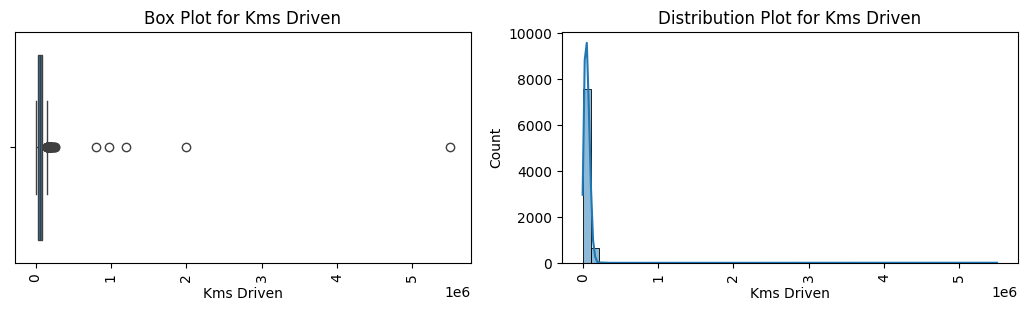

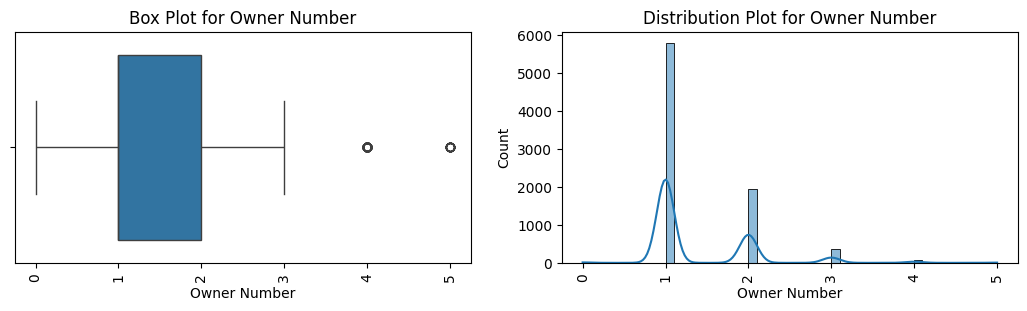

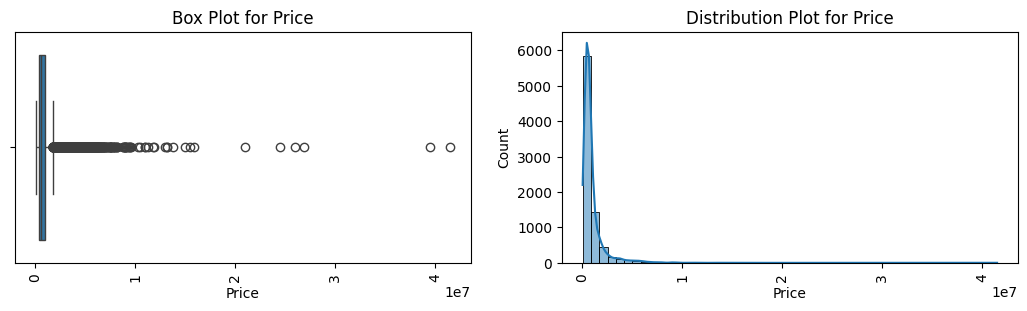

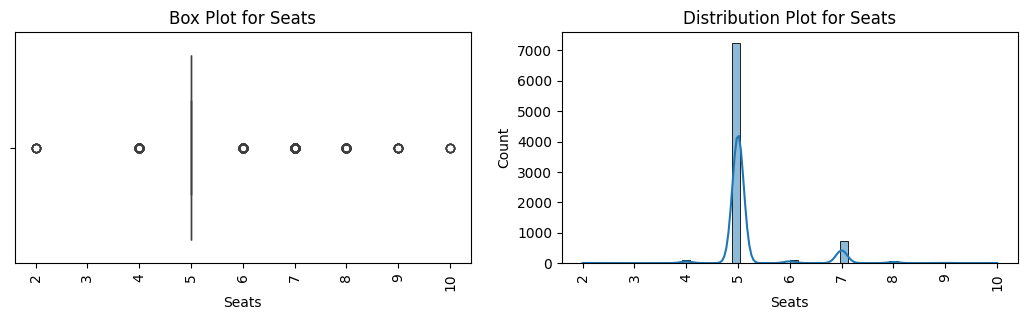

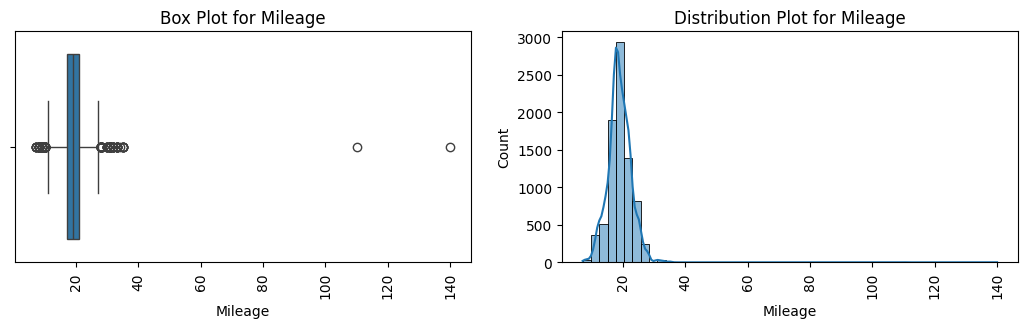

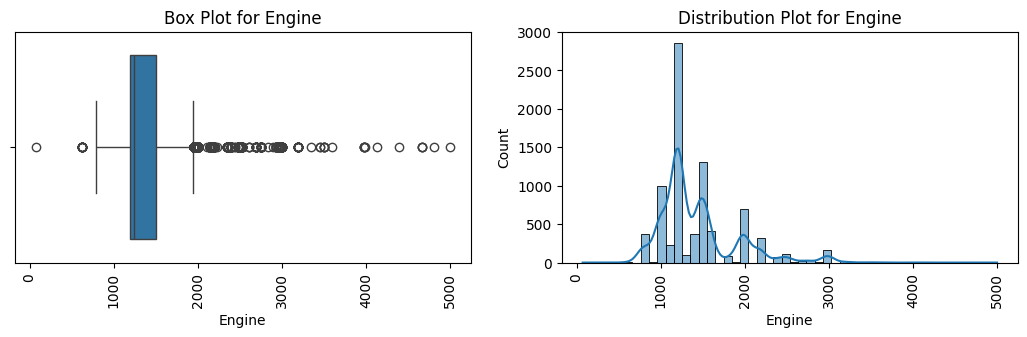

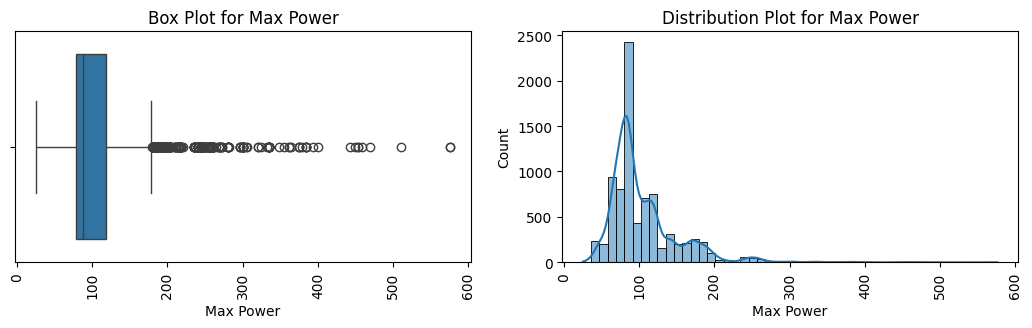

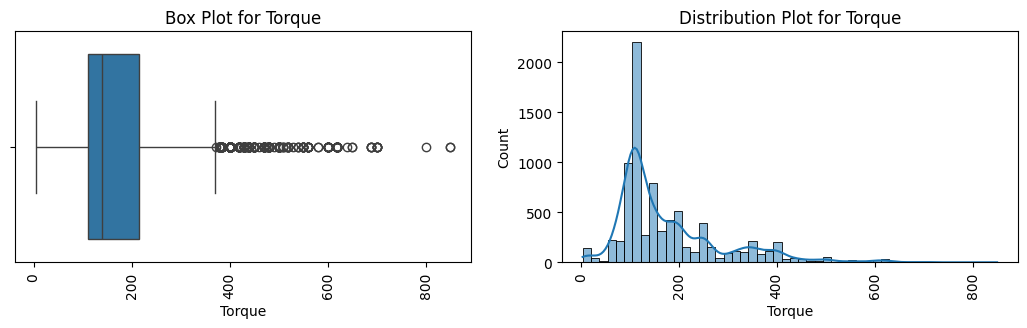

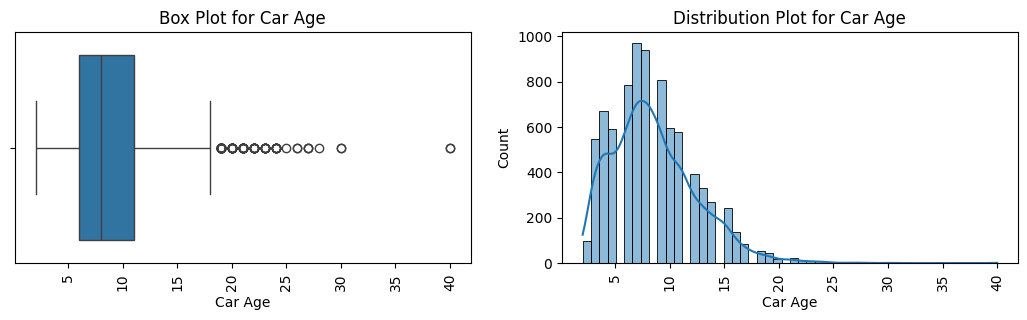

In [104]:
for col in numerical_features:
    plot(all_cities, col)

- Features like Kms Driven, Price, Engine, Max Power, and Torque have extreme outliers.
- The distribution is of Car Age is right-skewed, most cars are relatively new (5 to 12 years old).
- The Seats feature has no clear distribution as seats are ordinal numerical variables, 5-seater cars are the most common.
- The Owner Number feature is skewed towards lower owner numbers, meaning most cars are either first or second-owner.
- The distribution of Owner NUmber is right-skewed, with most cars are first or second-handed & the box plot shows only 2 outliers.
- The Mileage feature shows some outliers where these cars have unusually high or low mileage, & most cars having mileage between 18-20.

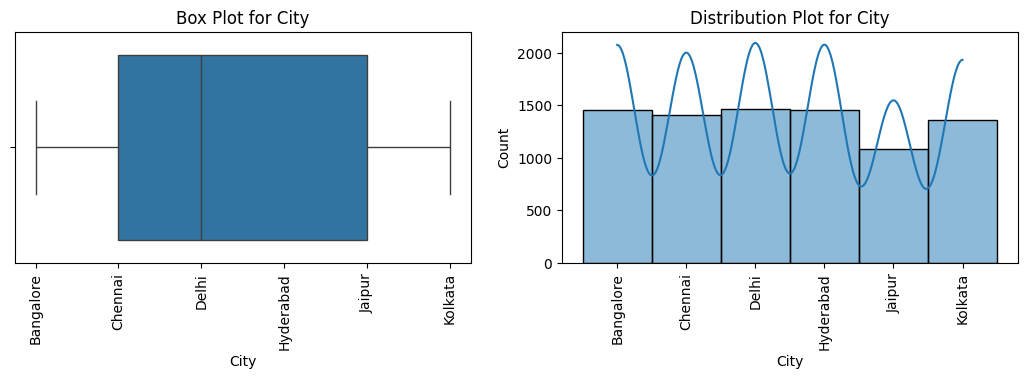

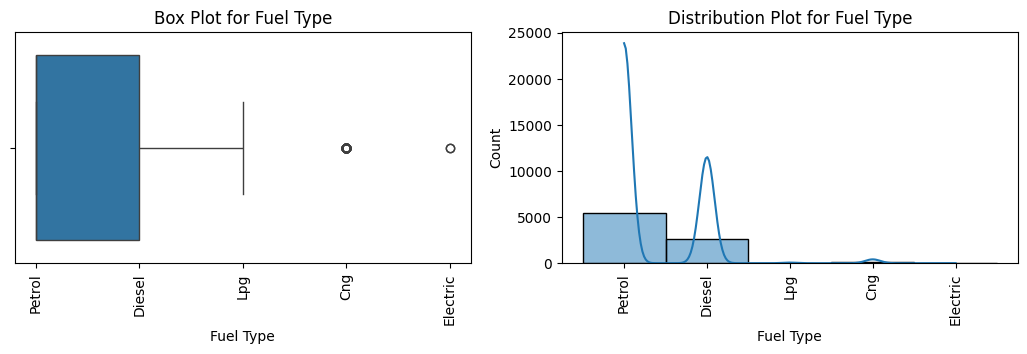

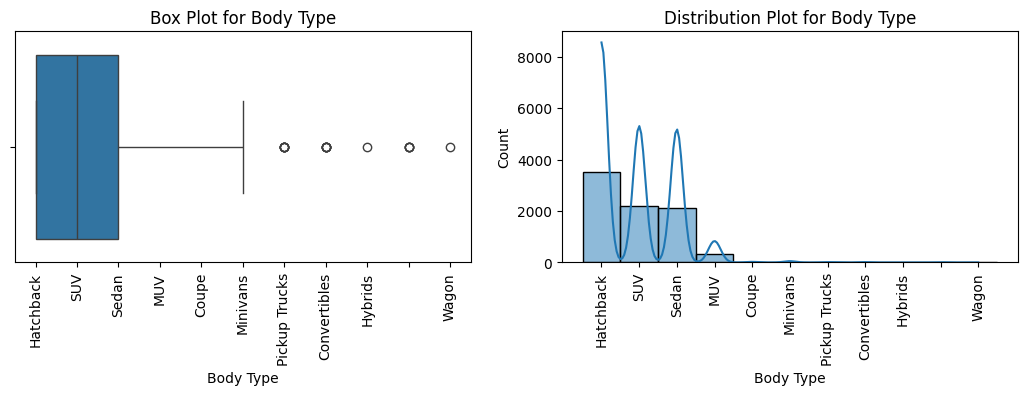

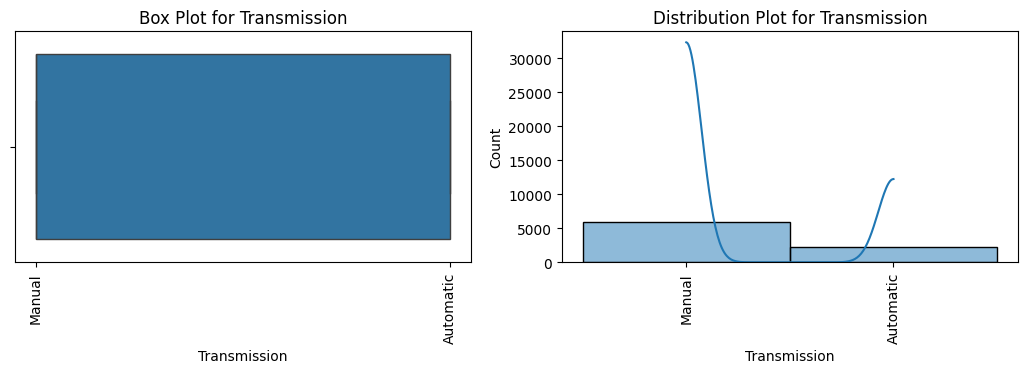

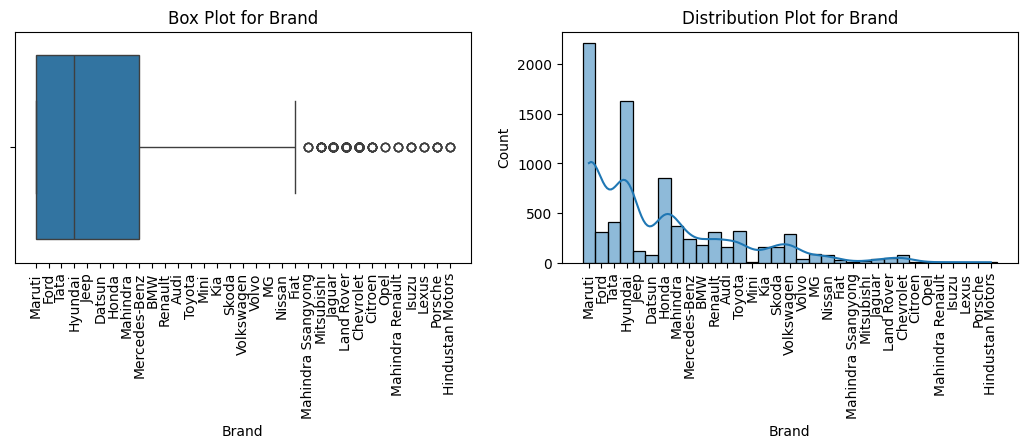

In [105]:
for col in categorical_features[:-2]:
    plot(all_cities, col)

- Body Type shows Hatchback, SUV, and Sedan dominate the dataset.
- Transmission feature has only 2 categories, where most cars are manual.
- The distribution of Body Type peaks at common car types like Hatchback, Sedan, SUV.
- Fuel Type has very few distinct categories (LPG, CNG & Electric), with most cars being petrol
- Brand distribution is highly skewed, with Maruti, Hyundai, & Toyota leading in volume. There are a few outliers.

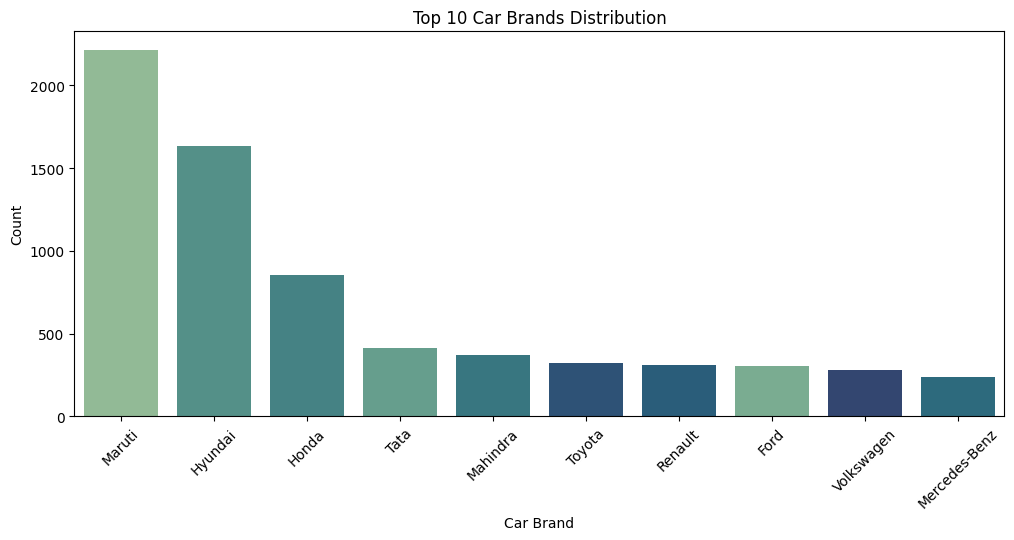

In [106]:
# Get the top 10 brands by count
top_10_brands = all_cities['Brand'].value_counts().nlargest(10).index

plt.figure(figsize=(12, 5))
sns.countplot(x=all_cities[all_cities['Brand'].isin(top_10_brands)]['Brand'], order=top_10_brands, 
              hue=all_cities[all_cities['Brand'].isin(top_10_brands)]['Brand'], palette="crest", legend=False)
        
plt.xticks(rotation=45)
plt.title("Top 10 Car Brands Distribution")
plt.xlabel("Car Brand")
plt.ylabel("Count")

plt.show()

 - Bivariate Analysis

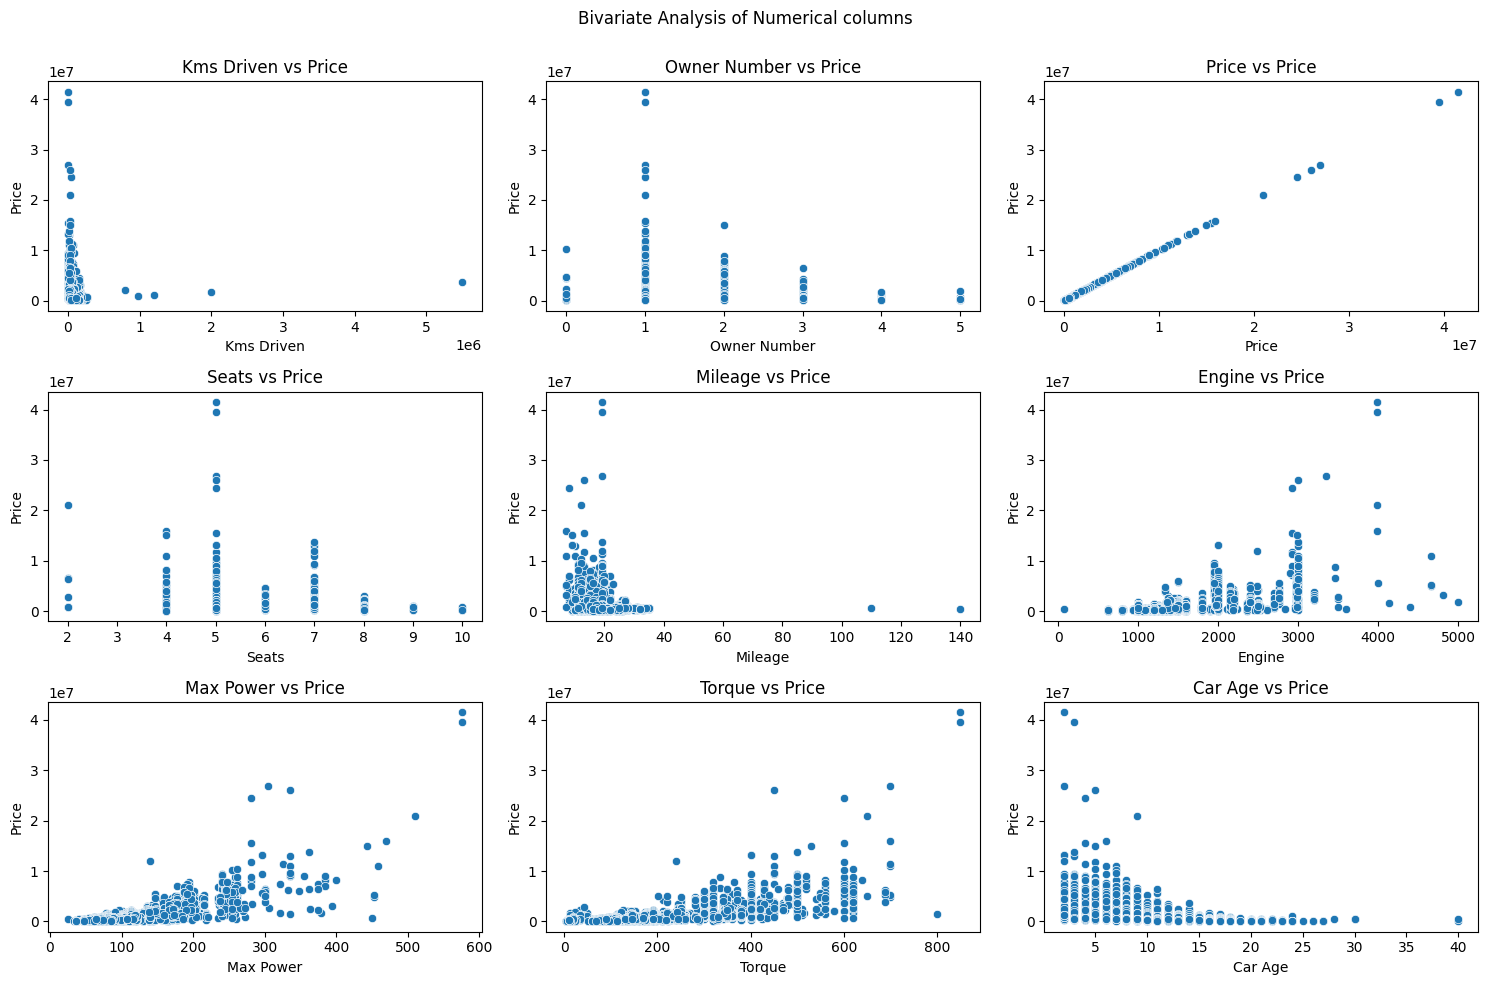

In [107]:
plt.figure(figsize=(15, 10))
plt.suptitle('Bivariate Analysis of Numerical columns\n')

for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=all_cities, x=col, y='Price')
    plt.title(f"{col} vs Price")

plt.tight_layout() 
plt.show()

- Car Age vs Price → Newer cars have higher prices.
- Owner Number vs Price → More owners means lower the price.
- Engine, Max Power, Torque → Higher values correspond to higher prices.
- Seats vs Price → No strong trend between seats and price, most cars have 4-5 seats.
- Mileage vs Price → Negative Correlation, as mileage increases, the price tends to decrease.
- Kms Driven vs Price → Weak correlation, older cars with high kms have lower prices, but some high-priced outliers exist.

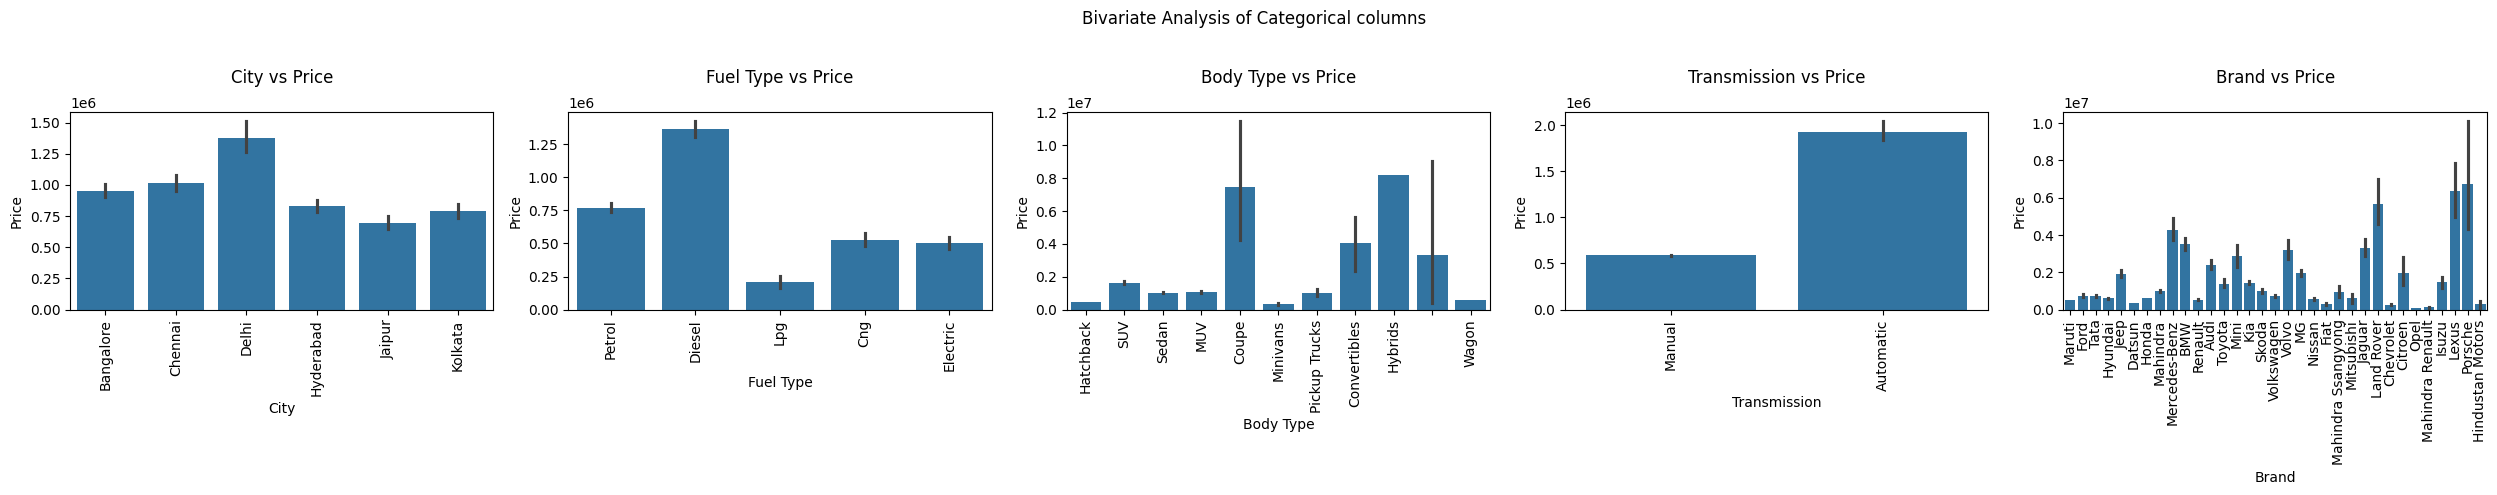

In [108]:
plt.figure(figsize = [25,5])
plt.suptitle('Bivariate Analysis of Categorical columns\n')

i=1
for col in categorical_features[:-2]:
        plt.subplot(1,5,i)
        sns.barplot(x=all_cities[col],y=all_cities['Price'])
        plt.title(f'{col} vs Price\n')
        plt.xlabel(col)
        plt.xticks(rotation=90)
        i+=1
plt.tight_layout()
plt.show()

- Fuel Type → Electric cars have the highest average price.
- Transmission → Automatic cars are priced significantly higher than manual.
- Body Type → Coupe, Hybrids & Convertibles are priced higher than other body types.
- Car Brand → Porsche, Lexus, Land are positioned at the higher end of the price spectrum.
- City → Delhi has the highest price variation, Jaipur have lower variability & other cities with moderate variation.

 - Multivariate Analysis

In [109]:
# Multicollinearity in Numerical features
all_cities[numerical_features].corr()

,Kms Driven,Owner Number,Price,Seats,Mileage,Engine,Max Power,Torque,Car Age
Kms Driven,1.000000,0.113317,-0.075382,0.074774,-0.012877,0.088429,-0.009155,0.045037,0.242253
Owner Number,0.113317,1.000000,-0.118430,0.011083,-0.078986,0.048287,-0.029943,-0.038433,0.385897
Price,-0.075382,-0.118430,1.000000,0.086652,-0.259710,0.552220,0.749052,0.648638,-0.297018
Seats,0.074774,0.011083,0.086652,1.000000,-0.295765,0.420899,0.176115,0.277135,-0.005639
Mileage,-0.012877,-0.078986,-0.259710,-0.295765,1.000000,-0.541336,-0.503899,-0.334237,-0.124184
Engine,0.088429,0.048287,0.552220,0.420899,-0.541336,1.000000,0.834271,0.803792,0.030604
Max Power,-0.009155,-0.029943,0.749052,0.176115,-0.503899,0.834271,1.000000,0.860612,-0.144688
Torque,0.045037,-0.038433,0.648638,0.277135,-0.334237,0.803792,0.860612,1.000000,-0.151053
Car Age,0.242253,0.385897,-0.297018,-0.005639,-0.124184,0.030604,-0.144688,-0.151053,1.000000


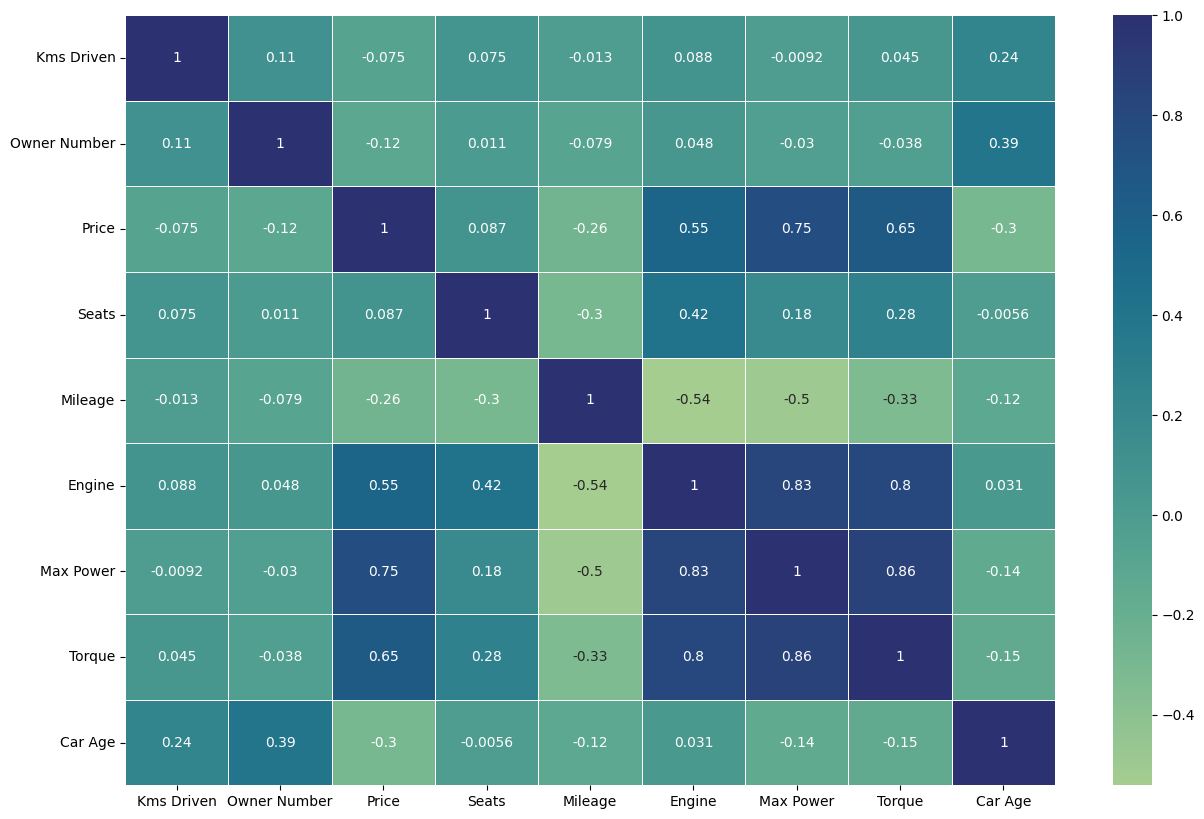

In [110]:
plt.figure(figsize = (15, 10))
sns.heatmap(all_cities[numerical_features].corr(), cmap = 'crest', annot = True, linewidth = 0.5)
plt.show()

- Max Power is highly correlated with Engine(0.83) & Torque(0.86) 
- Max Power is also highly correlated with Price, meaning that cars that have engines with high Max Power increase the value of Price. 
- Whereas Kms Driven, Owner Number, Mileage & Car Age tend to have a negative effect on Price, meaning that as the values of these features increase the value of Price tends to decrease .

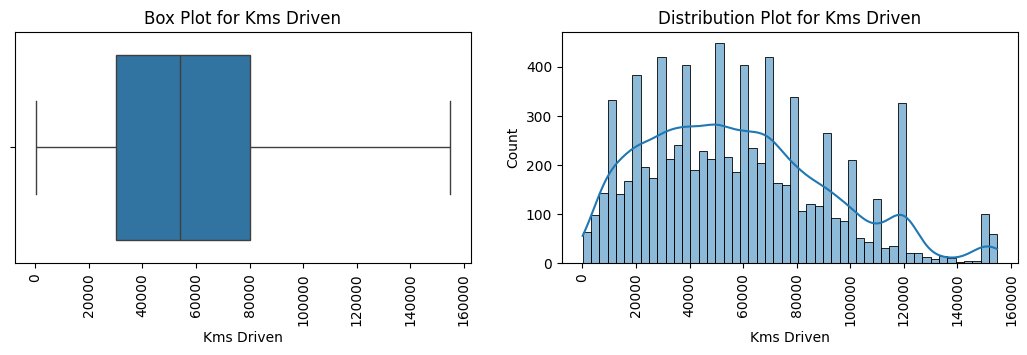

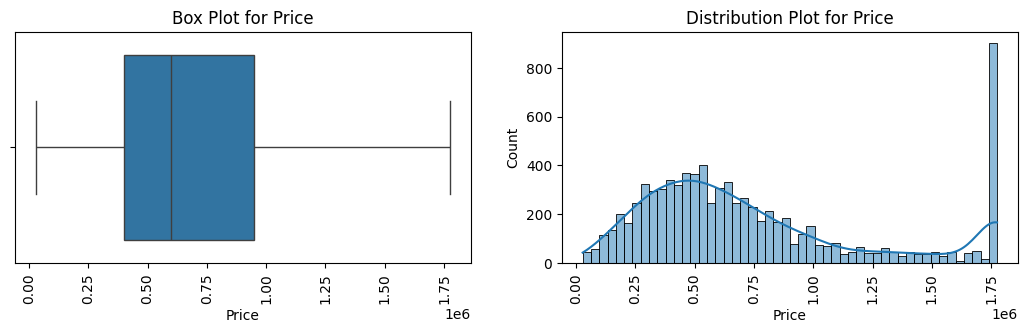

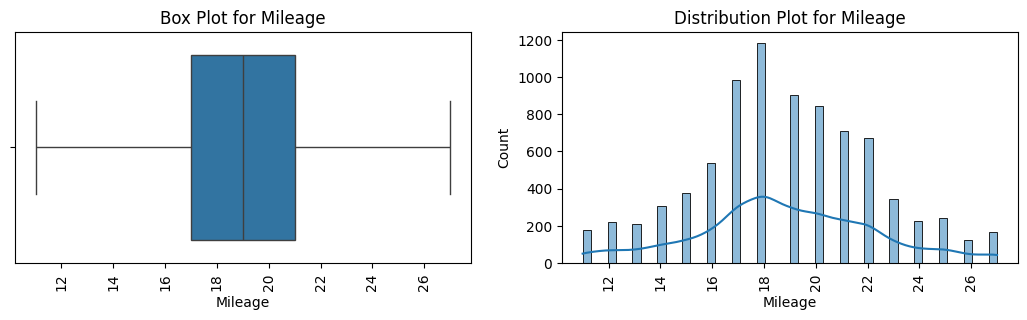

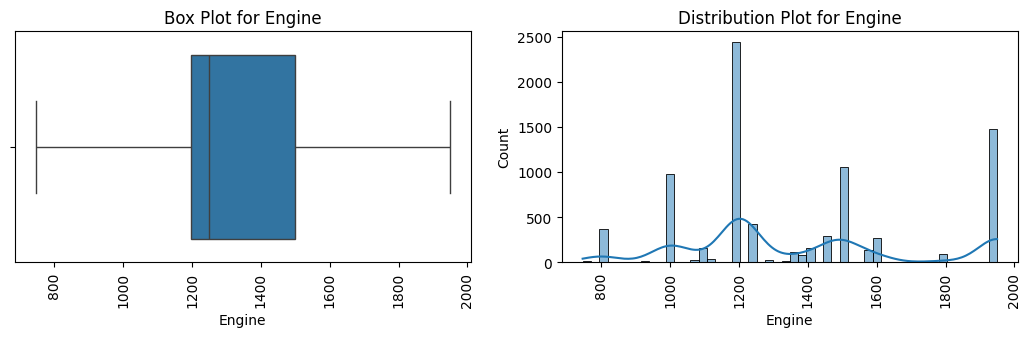

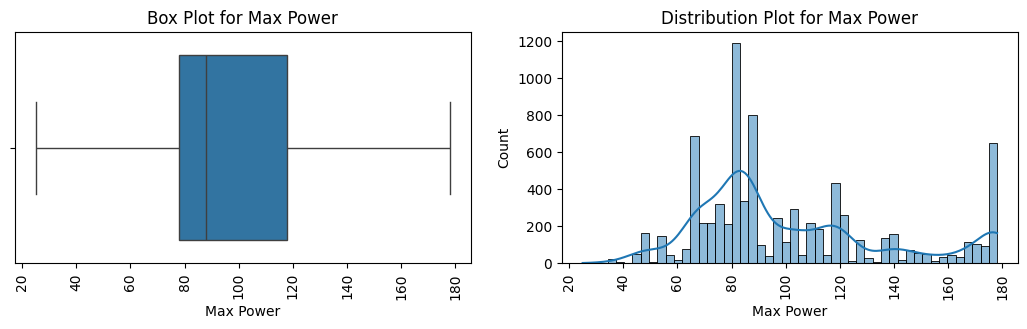

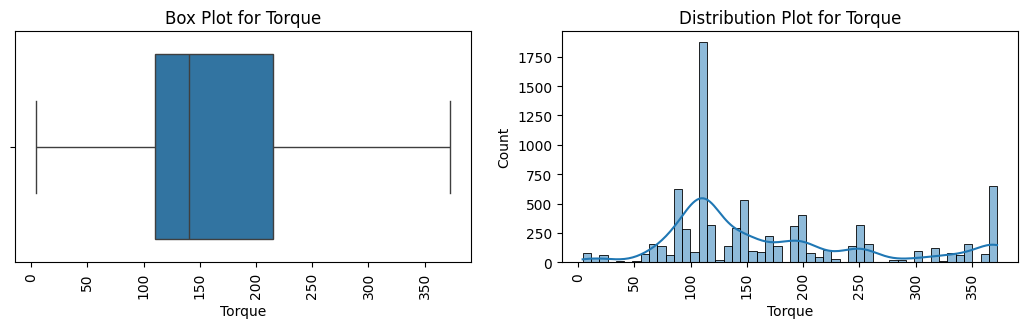

In [111]:
# Removing outliers using IQR & Clipping:

def outlier(all_cities, column):
    iqr = all_cities[column].quantile(0.75) - all_cities[column].quantile(0.25)
    upper_value = all_cities[column].quantile(0.75) + (1.5*iqr)
    lower_value = all_cities[column].quantile(0.25) - (1.5*iqr)
    all_cities[column] = all_cities[column].clip(lower_value, upper_value)
    
outlier(all_cities, 'Kms Driven')
outlier(all_cities, 'Price')
outlier(all_cities, 'Mileage')
outlier(all_cities, 'Engine')
outlier(all_cities, 'Max Power')
outlier(all_cities, 'Torque')

for i in ['Kms Driven','Price','Mileage','Engine','Max Power','Torque']:
    plot(all_cities,i)

### Identifying Important Features 

In [112]:
# Chi-square test
'''
Hypothesis:

Null Hypothesis (H₀): The categorical feature and Price are independent (no association).
Alternative Hypothesis (H₁): The categorical feature and Price are dependent (significant association exists).
'''
chi2_test = []

for feature in categorical_features:
    if chi2_contingency(pd.crosstab(all_cities['Price'], all_cities[feature]))[1] < 0.05:
        chi2_test.append('Reject Null Hypothesis')
    else:
        chi2_test.append('Accept Null Hypothesis')
test_result = pd.DataFrame(data=[categorical_features, chi2_test]).T
test_result.columns = ['Categorical Features', 'Hypothesis Result']

test_result

,Categorical Features,Hypothesis Result
0,City,Reject Null Hypothesis
1,Fuel Type,Accept Null Hypothesis
2,Body Type,Accept Null Hypothesis
3,Transmission,Reject Null Hypothesis
4,Brand,Accept Null Hypothesis
5,Model,Accept Null Hypothesis
6,Variant Name,Accept Null Hypothesis


In [113]:
# Removing features based on Chi-square test
all_cities.drop(['Model','Variant Name', 'Body Type'],axis = 1 ,inplace = True)
all_cities # Retaining Fuel Type & Brand based on domain knowledge

,City,Fuel Type,Kms Driven,Transmission,Owner Number,Brand,Price,Seats,Mileage,Engine,Max Power,Torque,Car Age
0,Bangalore,Petrol,120000.0,Manual,3,Maruti,400000,5,23,998.0,67,90.0,10
1,Bangalore,Petrol,32706.0,Manual,2,Ford,811000,5,17,1497.0,121,150.0,7
2,Bangalore,Petrol,11949.0,Manual,1,Tata,585000,5,23,1199.0,84,114.0,7
3,Bangalore,Petrol,17794.0,Manual,1,Hyundai,462000,5,19,1197.0,81,113.0,11
4,Bangalore,Diesel,60000.0,Manual,1,Maruti,790000,5,23,1248.0,88,200.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8221,Kolkata,Petrol,10000.0,Manual,1,Maruti,509999,5,25,998.0,65,89.0,3
8222,Kolkata,Petrol,120000.0,Manual,1,Maruti,180000,5,22,796.0,47,69.0,11
8223,Kolkata,Petrol,50000.0,Automatic,3,Mercedes-Benz,550000,5,11,1796.0,178,285.0,14
8224,Kolkata,Petrol,40000.0,Manual,1,Maruti,140000,5,18,1197.0,85,114.0,13


In [114]:
all_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8226 entries, 0 to 8225
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   City          8226 non-null   object 
 1   Fuel Type     8226 non-null   object 
 2   Kms Driven    8226 non-null   float64
 3   Transmission  8226 non-null   object 
 4   Owner Number  8226 non-null   int64  
 5   Brand         8226 non-null   object 
 6   Price         8226 non-null   int64  
 7   Seats         8226 non-null   int64  
 8   Mileage       8226 non-null   int64  
 9   Engine        8226 non-null   float64
 10  Max Power     8226 non-null   int64  
 11  Torque        8226 non-null   float64
 12  Car Age       8226 non-null   int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 835.6+ KB


In [115]:
# Converting float to int
all_cities['Kms Driven'] = all_cities['Kms Driven'].astype('int64')
all_cities['Engine'] = all_cities['Engine'].astype('int64')
all_cities['Torque'] = all_cities['Torque'].astype('int64')

In [116]:
all_cities.isnull().sum()

City            0
Fuel Type       0
Kms Driven      0
Transmission    0
Owner Number    0
Brand           0
Price           0
Seats           0
Mileage         0
Engine          0
Max Power       0
Torque          0
Car Age         0
dtype: int64

In [117]:
all_cities.describe().T

,count,mean,std,min,25%,50%,75%,max
Kms Driven,8226.0,57742.269025,33743.823826,101.0,30128.75,53919.0,80000.0,154806.0
Owner Number,8226.0,1.358254,0.638504,0.0,1.00,1.0,2.0,5.0
Price,8226.0,747981.553124,488156.230471,28000.0,400000.00,600000.0,950000.0,1775000.0
Seats,8226.0,5.203380,0.663851,2.0,5.00,5.0,5.0,10.0
Mileage,8226.0,18.809871,3.473681,11.0,17.00,19.0,21.0,27.0
Engine,8226.0,1372.404571,333.368080,745.0,1197.00,1248.0,1498.0,1949.0
Max Power,8226.0,101.344882,35.825648,25.0,78.00,88.0,118.0,178.0
Torque,8226.0,171.171165,92.894976,4.0,110.00,140.0,215.0,372.0
Car Age,8226.0,8.496839,3.903960,2.0,6.00,8.0,11.0,40.0


In [118]:
all_cities

,City,Fuel Type,Kms Driven,Transmission,Owner Number,Brand,Price,Seats,Mileage,Engine,Max Power,Torque,Car Age
0,Bangalore,Petrol,120000,Manual,3,Maruti,400000,5,23,998,67,90,10
1,Bangalore,Petrol,32706,Manual,2,Ford,811000,5,17,1497,121,150,7
2,Bangalore,Petrol,11949,Manual,1,Tata,585000,5,23,1199,84,114,7
3,Bangalore,Petrol,17794,Manual,1,Hyundai,462000,5,19,1197,81,113,11
4,Bangalore,Diesel,60000,Manual,1,Maruti,790000,5,23,1248,88,200,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8221,Kolkata,Petrol,10000,Manual,1,Maruti,509999,5,25,998,65,89,3
8222,Kolkata,Petrol,120000,Manual,1,Maruti,180000,5,22,796,47,69,11
8223,Kolkata,Petrol,50000,Automatic,3,Mercedes-Benz,550000,5,11,1796,178,285,14
8224,Kolkata,Petrol,40000,Manual,1,Maruti,140000,5,18,1197,85,114,13


In [119]:
# Cleaned Dataset
all_cities.to_csv("All_Cities_Cleaned.csv", index=False)